# Evaluation - different residual depths overview

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from pycm import ConfusionMatrix

## Load test predictions

In [3]:
# Load training history
baseline_history = np.load("../results/baseline_(resnet15)_training_history.npy", allow_pickle=True)
train_noise_history = np.load("../results/(resnet-6-block-noise)_training_history.npy", allow_pickle=True)

# Load test predictions
baseline_predictions = np.load("../results/baseline_(resnet15)_predictions.npy")
noise_predictions = np.load("../results/(resnet-6-block-noise)_predictions.npy")

# Load test labels
labels = np.load("../results/baseline_(resnet15)_test_labels.npy")

# Load one-hot-mapping
one_hot_mapping = np.load("one_hot_mapping.npy", allow_pickle=True)

## Training run comparison

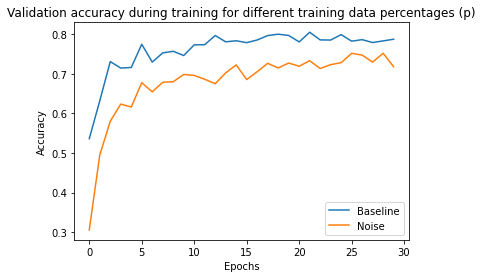

In [4]:
plt.plot(baseline_history.item().get("val_accuracy"), label="Baseline")
plt.plot(train_noise_history.item().get("val_accuracy"), label="Noise")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation accuracy during training for different training data percentages (p)")
plt.legend()
plt.show()

## FAR - FRR results

I used [this tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) to construct the ROC curve.

In [3]:
def compute_roc_curve(test_labels, test_predictions):
    far = dict()
    frr = dict()
    n_classes = 35

    # Compute fpr and tpr for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_predictions[:, i])
        fnr = 1 - tpr

        # store results
        frr[i] = fnr
        far[i] = fpr

    # First aggregate all false alarm rates
    all_far = np.unique(np.concatenate([far[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_frr = np.zeros_like(all_far)
    for i in range(n_classes):
        mean_frr += np.interp(all_far, far[i], frr[i])

    # Average the false rejection rates by the number of classes
    mean_frr /= n_classes

    far["macro"] = all_far
    frr["macro"] = mean_frr
    
    return far, frr
    
far_baseline, frr_baseline = compute_roc_curve(labels, baseline_predictions)
far_noise, frr_noise = compute_roc_curve(labels, noise_predictions)

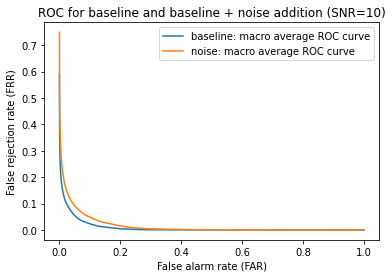

In [4]:
# Show the ROC curve
plt.plot(far_baseline['macro'], frr_baseline['macro'], label=f"baseline: macro average ROC curve")
plt.plot(far_noise['macro'], frr_noise['macro'], label=f"noise: macro average ROC curve")
plt.xlabel("False alarm rate (FAR)")
plt.ylabel("False rejection rate (FRR)")
plt.title("ROC for baseline and baseline + noise addition (SNR=10)")
plt.legend()
plt.show()